## Linear Regression
### Brynn:

### Section 002


In [16]:
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import RidgeCV, LassoCV
from itertools import combinations
from matplotlib import pyplot as plt

## Problem 1
Write a function that takes as input $X$ and **y** as defined on page 1. Call this function **ols**. This function should return the least squares estimator for $\beta$ as a numpy array.

In [4]:
def ols(X, y):
    """ Solves for the least squares estimator.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpyarray
    """
    # reshape if necessary
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    # add a column of ones to X to account for β_0
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # solve for β
    β = np.linalg.inv(X.T @ X) @ (X.T) @ y

    return β

## Problem 2
Find the least squares estimator for $\beta$ using this random data. 
Produce a plot showing the random data and the line of best fit determined by the least squares estimator for $\beta$. 
Your plot should include a title, axis labels, and a legend. 

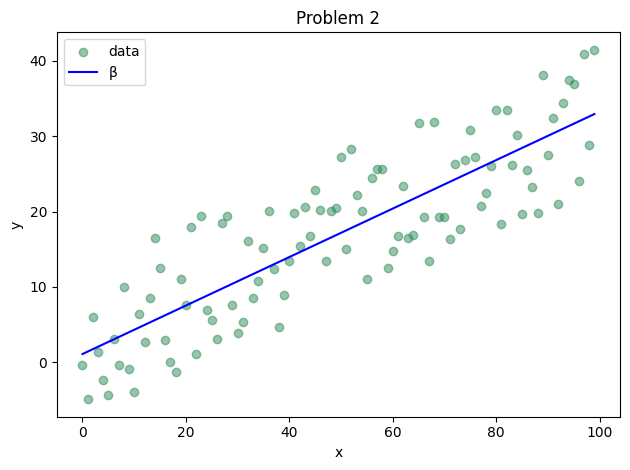

In [5]:
# initialization from lab guide
n = 100 # Number of points to generate
X = np.arange(100) # The input X for the function ols
ε = np.random.uniform(-10,10, size=(100,)) # Noise to generate random y - coordinates
y = 0.3*X + 3 + ε # The input y for the function ols

# solve
β = ols(X, y)

# plot
plt.scatter(X, y, c='seagreen', alpha=0.5, label='data')
plt.plot(X, β[0] + β[1]*X, c='b', label='β')

plt.title('Problem 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()


## Problem 3
Write a function that finds the least squares estimator for rank-deficient models using the SVD. 
The function should still take $X$ and **y** as inputs. Call the function **svd_ols** and return the least squares estimator for $\beta$ as a numpy array.

In [6]:
def svd_ols(X, y):
    """
    Solves for the least squares estimator using the SVD.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpy array
    """
    # add a column of ones to X to account for β_0
    X = np.hstack((np.ones((X.shape[0], 1)), X))


    U, S, Vh = np.linalg.svd(X, full_matrices=False)     # get SVD

    # solve for β
    β = Vh.T @ np.diag(1/S) @ (U.T) @ y

    return np.array(β)
    

## Problem 4
Use your function **svd_ols** to find the least squares estimator for a cubic polynomial. 
Create a plot that shows a scatter plot of the data and a curve using the least squares estimator. 
Your plot should include a title, axis labels, and a legend.

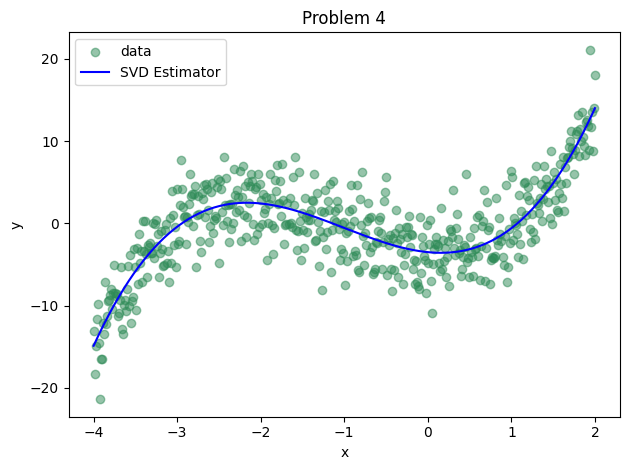

In [7]:
# initialization from lab guide
x = np.linspace(-4, 2, 500)
y = x**3 + 3*x**2 - x - 3.5
eps = np.random.normal(0, 3, len(y)) # Create noise
y += eps # Add noise to randomize data

# solve
X = np.vstack((x, x**2, x**3)).T
β = svd_ols(X, y)

# plot
plt.scatter(x, y, c='seagreen', alpha=0.5, label='data')
plt.plot(x, β[0] + β[1]*x + β[2]*x**2 + β[3]*x**3, c='b', label='SVD Estimator')

plt.title('Problem 4')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

## Problem 5
The file **realestate.csv** contains transaction data from 2012-2013. 
It has columns for transaction data, house age, distance to nearest MRT station, number of convenience stores, latitude, longitude, and house price of unit area.
Each row in the array is a separate measurement.

Find the combination of variables that builds the model with the best $R^2$ value when predicting **house price of unit area**. Use statsmodels to build each model and calculate $R^2$. Use **statsmodels** to build each model and calculate $R^2$. Using the same combination of variables, time the methods **ols**, **svd_ols**, and **statsmodels** . Return a list with the first element being a tuple of times for each method and the second element being the best $R^2$ value from the first part of the problem.

In [8]:
# helper functions for problem 5
def get_ols_rsquared(X, y):
    # computes ols r^2 using numpy
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    β = np.linalg.inv(X.T @ X) @ X.T @ y
    y_pred = X @ β
    res = y - y_pred
    rss = np.sum(res**2)
    tss = np.sum((y - np.mean(y))**2)
    rsquared = 1 - rss/tss
    return rsquared

def get_ols_svd_rsquared(X, y):
    # computes ols r^2 using svd
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    U, s, Vh = np.linalg.svd(X, full_matrices=False)
    s_inv = np.diag(1/s)
    β = Vh.T @ s_inv @ U.T @ y
    y_pred = X @ β
    res = y - y_pred
    rss = np.sum(res**2)
    tss = np.sum((y - np.mean(y))**2)
    rsquared = 1 - rss/tss
    return rsquared

def get_statsmodel_rsquared(X, y):
    # computes r^2 using ols
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.rsquared

In [13]:
def problem5():
    """
    Find the best R2 value using statsmodels.
    Then time ols, svd_ols, and statsmodlels.
    Returns:
        list(): a tuple of times and the best R2 value
    """
    # load & organize data
    data = pd.read_csv('realestate.csv', index_col=0)
    ind_vars = ['X2 house age',
                'X3 distance to the nearest MRT station',
                'X4 number of convenience stores',
                'X5 latitude',
                'X6 longitude']
    y = data['Y house price of unit area'].values

    # all combinations of independent variables
    combos = list(combinations(ind_vars, len(ind_vars)))

    # initialize
    best_rsquared = -float('inf')
    best_combo = None
    ols_times = []
    svd_ols_times = []
    statsmodels_times = []

    # iterate through each combination of features
    for combo in combos:
        # get current combination of features
        X = data[list(combo)].values

        # time & compute r^2 using ols
        start = time.time()    # start time
        rsquared_ols = get_ols_rsquared(X, y)
        end = time.time()       # end time
        ols_times.append(end - start)

        # time & compute r^2 using svd ols
        start = time.time()    # start time
        rsquared_svd_ols = get_ols_svd_rsquared(X, y)
        end = time.time()       # end time
        svd_ols_times.append(end - start)

        # time & compute r^2 using statsmodels
        start = time.time()    # start time
        rsquared_statsmodels = get_statsmodel_rsquared(X, y)
        end = time.time()       # end time
        statsmodels_times.append(end - start)

        # check if the combination has the best r^2
        if rsquared_statsmodels > best_rsquared:
            best_rsquared = rsquared_statsmodels
            best_combo = combo

    # compute average times
    ols_avg = sum(ols_times) / len(ols_times)
    svd_ols_avg = sum(svd_ols_times) / len(svd_ols_times)
    statsmodels_avg = sum(statsmodels_times) / len(statsmodels_times)

    return [(ols_avg, svd_ols_avg, statsmodels_avg), best_rsquared]

problem5()

[(0.00022101402282714844, 0.00025391578674316406, 0.0007011890411376953),
 0.5711617064827439]

## Problem 6
Use the file **realestate.csv** and the Python Example on page 4 as a template for constructing **y** and $X$ and calculating model AIC and BIC. 
For the dependent variable, use **house price of unit area**. 
For the independent variables, use **distance to the nearest MRT station**, **number of convenience stores**, **latitude**, and **longitude**.

Find the model that has the lowest AIC and the model that has the lowest BIC. Are they the same model? Print the features of the model with the lowest AIC as a list.

In [15]:
def prob6():
    # load & organize data
    data = pd.read_csv('realestate.csv', index_col=0)
    # define dependent & independent variables
    ind_vars = ['X2 house age',
                'X3 distance to the nearest MRT station',
                'X4 number of convenience stores',
                'X5 latitude',
                'X6 longitude']
    y = data['Y house price of unit area']

    # initialize
    best_aic = float('inf')
    best_bic = float('inf')
    best_aic_features = None
    best_bic_features = None

    # iterate through all (non-empty) combos of the independent variables
    for i in range(1, len(ind_vars) + 1):
        for combo in combinations(ind_vars, i):
            X = data[list(combo)]

            # fit the model
            X_curr = sm.add_constant(X)
            model = sm.OLS(y, X_curr).fit()

            # check if we have a new best aic or bic
            if model.aic < best_aic:
                best_aic = model.aic
                best_aic_features = combo

            if model.bic < best_bic:
                best_bic = model.bic
                best_bic_features = combo


    print(f'List of features of the model with the lowest AIC: {list(best_aic_features)}')
    if best_aic_features == best_bic_features:
        print('The model with the lowest AIC is the same as the model with the lowest BIC')
    else:
        print('The model with the lowest AIC is not the same as the model with the lowest BIC')
prob6()

List of features of the model with the lowest AIC: ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude']
The model with the lowest AIC is the same as the model with the lowest BIC


## Problem 7
Use Ridge and Lasso Regression to model **house price of unit area** from the file **realestate.csv**.
Before fitting each model, run a GridSearch on $\alpha$ to find the optimal value.
Then use the optimal $\alpha$ to fit the model.
Once you have fit the model, you can use the **score** method to get $R^2$. 
Print $R^2$ for each model as a tuple. 

In [ ]:
def prob7():
    # load & organize data
    data = pd.read_csv('realestate.csv', index_col=0)
    # define dependent & independent variables
    ind_vars = ['X2 house age',
                'X3 distance to the nearest MRT station',
                'X4 number of convenience stores',
                'X5 latitude',
                'X6 longitude']
    y = data['Y house price of unit area']
    X = data[ind_vars]

    # initialize α's for grid search
    alphas = np.logspace(-6, 6, 13)

    # set up models
    ridge = RidgeCV(alphas=alphas, store_cv_values=True)
    lasso = LassoCV(alphas=alphas, cv=5)

    # fit models
    ridge.fit(X, y)
    lasso.fit(X, y)

    # calc r^2
    ridge_rsquared = ridge.score(X, y)
    lasso_rsquared = lasso.score(X, y)

    # print results
    return ridge_rsquared, lasso_rsquared

sol = prob7()

In [19]:
print(sol)

(0.571144155202517, 0.5710797337360025)
